## Week 3: Vision


CIFAR-10 데이터셋을 사용합니다. CIFAR-10은 MNIST와 함께 딥러닝 학습의 toy example에 가장 많이 사용되는 데이터셋으로, 32x32크기의 컬러 이미지가 train 50000장, test 10000장 존재합니다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# 데이터 변환 (이미지를 텐서로 변환하고 정규화)
# VGG, ResNet은 Xavier, He Initialization을 사용하는데,
# 이 초기화방법은 입력의 평균이 0이라는 가정 하에 이루어지는 가중치 초기화 방법입니다.
transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 255] => [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 입력의 평균을 0으로 맞춤. [0, 1] -> [-1, 1]
])

# CIFAR-10 데이터셋 다운로드 및 로드
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# DataLoader로 배치 구성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


주어진 데이터의 특징을 파악하는 것 또한 중요합니다.

Text(0.5, 1.0, 'Class distribution in test set')

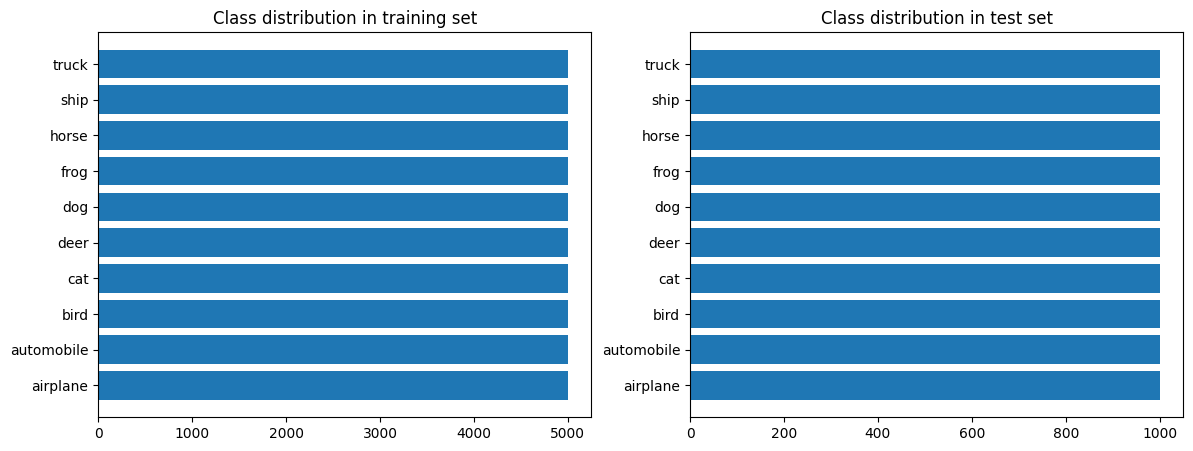

In [ ]:
# 데이터 확인
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
classes = train_dataset.classes
class_counts = Counter(train_dataset.targets)
plt.barh(classes, [class_counts[label_idx] for label_idx in range(len(classes))])
plt.title('Class distribution in training set')

plt.subplot(1,2,2)
classes = test_dataset.classes
class_counts = Counter(test_dataset.targets)
plt.barh(classes, [class_counts[label_idx] for label_idx in range(len(classes))])
plt.title('Class distribution in test set')

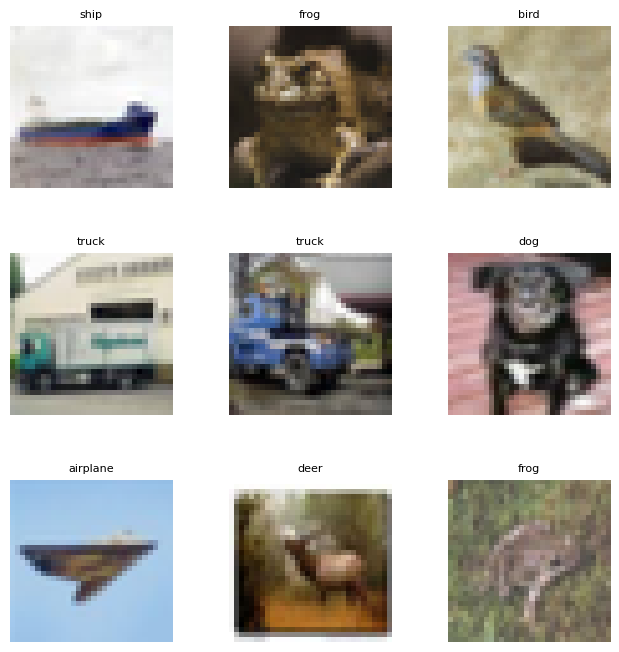

In [ ]:
labels = train_dataset.classes

# Let's view more images in a grid format
# Define the dimensions of the plot grid
W_grid = 3
L_grid = 3

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (8,8))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(train_dataset) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_train)
    X_train, y_train = train_loader.dataset[index]
    # read and display an image with the selected index
    axes[i].imshow((X_train.permute(1,2,0)+1)/2)        # 앞서 dataloader를 만들 때 이미지 범위를 [-1, 1]로 했으므로, 다시 [0, 1]로 원복
    label_index = int(y_train)
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchsummary import summary
from torch import optim

import time

In [ ]:
# 런타임 > 런타임 유형 변경 > 하드웨어가속기를 T4 GPU로 변경
! nvidia-smi

Sun Aug 24 18:55:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Utils 부분도 실행시켜주세요.


In [ ]:
#Utils

class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the k top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

## Task - ResNet

아래 그림은 ResNet34의 구조입니다. 이 구조를 보고, ResNet을 완성시키는 것이 이번 주 과제입니다.

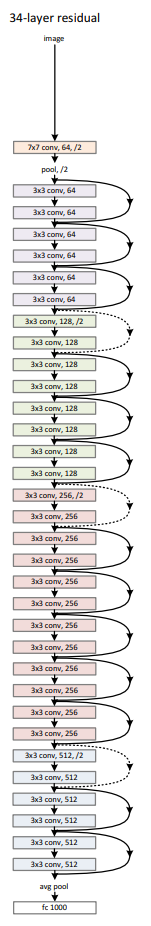

시작에는, 3개의 채널을 가지는 RGB Image를 받아 7*7 크기 kernel과 Stride 2를 거치는 기본 layer를 지납니다. 이때 out_channel 수는 64입니다.

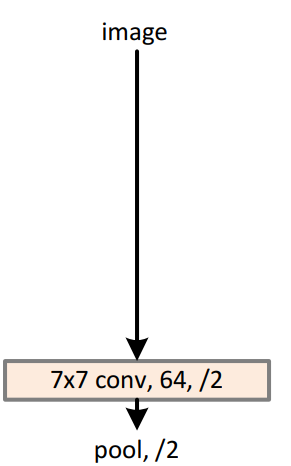

따라서 ResNet 클래스에서 정의되는 구조는 다음과 같습니다.

In [ ]:
#self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2,padding=3, bias=False)

다음으로 ResNet의 구조를 보면, 다음과 같이 동일한 여러 블록들이 반복되는 구조를 가집니다. 따라서 우리는 이를 BasicBlock으로 정의해 반복적으로 사용이 용이하게끔 합니다.



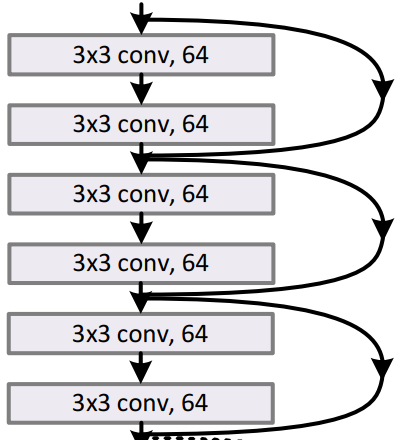

반복되는 횟수는 ResNet(N)에서 N의 갯수에 따라 다릅니다. ResNet18,ResNet34는 BasicBlock만을 사용할 것입니다. 이번 과제의 ResNet34의 경우 3x3 conv,64 가 2번 + Residual Connection을 가지는 구조가 각각 [3,4,6,3]번 반복되는 구조입니다.

In [ ]:
'''def resnet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)'''

## 과제1. BasicBlock 내부 구현하기

위에서 설명드린 BasicBlock을 만드는 것이 첫 번째 과제입니다. init의 변수를 참고해서, BasicBlock의 forward 함수를 완성해주세요.


참고) BasicBlock의 구조는 다음과 같습니다.

입력x -> (conv1 layer -> batchnorm layer -> ReLU -> conv2 layer -> batchnorm layer) -> ReLU(다운샘플한 입력x + 이전 출력) = 최종출력

downsample이란 residual connection을 위해 만들어진 추가 layer라고 생각하시면 편합니다. residual connection 시에 크기가 맞지 않으면 당연히 + 연산을 할 수 없습니다.

예) stride=2를 적용하면 해상도가 달라짐.

따라서  원본x에 downsample을 적용해 크기를 맞춰줍니다.

In [ ]:
class BasicBlock(nn.Module):
    """
    ResNet Basic Block without expansion attribute, always maintains in/out channels.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        '''what is downsample?'''
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out




## 과제2. ResNet Class 구현하기

두 번째로는 ResNet 클래스를 구현해봅니다. 각 layer1,2,3,4의 몇 개의 out_channels가 들어가야 하는지 원본 논문 구조를 보고 채워넣으시면 됩니다.



_make_layer에서는 BasicBlock을 이용해 ResNet내부에 사용될 layer를 만듭니다. 여기서 중요한 것은 downsample으로, conv layer와 batch norm layer를 포함해 하나의 layer로 만들어주세요.(힌트 : nn.Sequential ())

forward에서는 conv1 -> bn1 -> relu -> maxpool -> layer 1,2,3,4 -> avgpool -> flatten -> fc layer 순으로 채우시면 됩니다!

다 하셨다면 나머지 train 코드를 실행해 top-1 accuracy가 올바르게 나오는지 체크해주세요. 20에포크 기준 80 근방이 나왔다면 OK입니다.

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.in_channels = 64
        # Initial convolution and pooling
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # Residual layers

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        # If the number of channels or spatial size changes, define downsample
        if stride != 1 or self.in_channels != out_channels:

            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):

        # stem layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # fc
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)


        return x

# Factory functions using only BasicBlock

def resnet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


## Training

In [ ]:
def train(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss, accuracy
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            progress.print(i)

    print('==> Train Accuracy: Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg

def test(test_loader,epoch, model):
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    model.eval()
    for i,(input,target) in enumerate(test_loader):
        input = input.cuda()
        target = target.cuda()

        output = model(input)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))
    print('==> Test Accuracy:  Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg

## Hyperparameter Setting

In [ ]:
model_name = 'ResNet34' # resnet18, resnet50, resnet101,
batch_size = 64  # Input batch size for training (default: 128)
epochs = 20 # Number of epochs to train (default: 200)
learning_rate = 0.001 # Learning rate
data_augmentation = True # Traditional data augmentation such as augmantation by flipping and cropping?
path2weights = './'+model_name+'.pth'    # route for model saving
path2LatestWeights = ','+model_name+'_latest.pth'    # route for latest model saving

seed = 0 # Random seed (default: 0)
print_freq = 100
cuda = torch.cuda.is_available()
cudnn.benchmark = True  # Make training should go faster for large models

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [ ]:
model = resnet34().cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

from torch.optim.lr_scheduler import StepLR, MultiStepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

criterion = torch.nn.CrossEntropyLoss(reduction='sum').cuda()

## Train Model

In [ ]:
best_acc = 0
for epoch in range(epochs):
    print("\n----- epoch: {}/{}, lr: {} -----".format(
        epoch+1, epochs, optimizer.param_groups[0]["lr"]
        ))

    # train for one epoch
    start_time = time.time()
    train(train_loader, epoch, model, optimizer, criterion)
    test_acc = test(test_loader,epoch,model)

    elapsed_time = time.time() - start_time
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))

    # learning rate scheduling
    scheduler.step()

    # Save model for best accuracy
    if best_acc < test_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), path2weights)

#torch.save(model.state_dict(), path2LatestWeights)
print(f"Best Top-1 Accuracy: {best_acc}")


----- epoch: 1/20, lr: 0.001 -----
Epoch: [0][  0/782]	Time  2.703 ( 2.703)	Loss 1.5854e+02 (1.5854e+02)	Acc@1   7.81 (  7.81)	Acc@5  60.94 ( 60.94)
Epoch: [0][100/782]	Time  0.028 ( 0.062)	Loss 1.1448e+02 (1.2451e+02)	Acc@1  32.81 ( 30.01)	Acc@5  89.06 ( 81.76)
Epoch: [0][200/782]	Time  0.028 ( 0.045)	Loss 1.1943e+02 (1.1452e+02)	Acc@1  34.38 ( 34.67)	Acc@5  82.81 ( 85.71)
Epoch: [0][300/782]	Time  0.028 ( 0.040)	Loss 1.0044e+02 (1.0841e+02)	Acc@1  48.44 ( 38.26)	Acc@5  90.62 ( 87.68)
Epoch: [0][400/782]	Time  0.030 ( 0.037)	Loss 8.3867e+01 (1.0405e+02)	Acc@1  62.50 ( 40.91)	Acc@5  90.62 ( 88.89)
Epoch: [0][500/782]	Time  0.028 ( 0.037)	Loss 9.0928e+01 (1.0090e+02)	Acc@1  50.00 ( 43.00)	Acc@5  89.06 ( 89.82)
Epoch: [0][600/782]	Time  0.028 ( 0.035)	Loss 7.3443e+01 (9.7595e+01)	Acc@1  64.06 ( 45.01)	Acc@5  90.62 ( 90.64)
Epoch: [0][700/782]	Time  0.029 ( 0.034)	Loss 8.7237e+01 (9.5066e+01)	Acc@1  57.81 ( 46.54)	Acc@5  87.50 ( 91.23)
==> Train Accuracy: Acc@1 47.684 || Acc@5 91.624
==>